In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.append(os.path.expanduser(os.path.join('~','Documents', 'projects', 'coronavirus')))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import src.tools as tools
import plotly.express as px
from scipy.integrate import odeint
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution
import scipy.integrate as integrate
from src.data_downloader import DATA_REPOS, download_from_repo

### update data from repos

In [119]:
dest='/home/maurizio/Documents/projects/coronavirus/data'

In [120]:
download_from_repo(DATA_REPOS['world']['url'], filenames=DATA_REPOS['world']['streams'], dest=dest)

last commit  2020-03-29 00:55:34


In [121]:
download_from_repo(DATA_REPOS['italy']['url'], filenames=DATA_REPOS['italy']['streams'], dest=dest)

last commit  2020-03-28 18:27:59


## SIRD Model definition

In [41]:
# SIR model differential equations
def SIR_deriv(y, t, N, beta, gamma, theta):
    S, I, R, D = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    dDdt = theta * I
    return dSdt, dIdt, dRdt, dDdt

def SIRModel_solver(t, beta, gamma, theta):
    return SIRModel(t, beta, gamma, theta)[3] # returns just D for optimizer

def SIRModel(t, beta, gamma, theta):
    # Initial conditions vector
    y0 = S0, I0, R0, D0
    # Integrate the SIR equations over time t
    ret = odeint(SIR_deriv, y0, t, args=(N, beta, gamma, theta))
    S, I, R, D = ret.T
    return S, I, R, D

def diff_ev_solver(params):
    beta, gamma, theta = params
    return np.mean(np.abs(SIRModel_solver(x_fit, beta, gamma, theta) - y_fit))

### toy example

beta:  0.2
gamma:  0.1
theta:  0.015
r0:  2.0
mean period of time of infection:  10.0


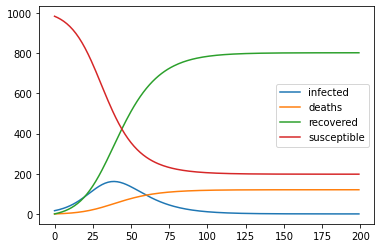

In [42]:
N = 1000 # total population Italy
I0 = 16 # Initial number of infected people (10x official estimates hypothesis)
R0 = 0 # Initial number of recovered
S0 = N - I0 - R0 # Initial susceptible population to infection.
D0 = 0 # number of deaths at initial time

params = (0.2, 0.1, 0.015)
S, I , R, D = SIRModel(range(200), *params)
print('beta: ', params[0])
print('gamma: ', params[1])
print('theta: ', params[2])
print('r0: ', params[0]/params[1])
print('mean period of time of infection: ', 1/params[1])

plt.plot(I, label='infected')
plt.plot(D, label='deaths')
plt.plot(R, label='recovered')
plt.plot(S, label='susceptible')
#plt.yscale('log')
#ax.yaxis.set_major_formatter(ScalarFormatter())

#plt.ylim(0,10000)
plt.legend()

### fit to official death data

calibrating with genetic algorithm...
beta:  -2.1934205106297107
gamma:  -2.3857984215432992
theta:  0.0032868839472196282
r0:  0.9206337413345083
mean period of time of infection:  -0.41914689479638895
max number of infections  228313.70791078097
max number of deaths  15061.060729179759
mae  56.972442606217115


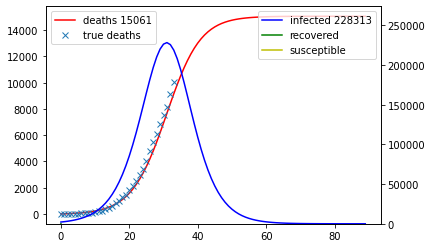

In [44]:
use_differential_evolution = True
cases_multiplier = 10
df = pd.read_csv('../data/dpc-covid19-ita-andamento-nazionale.csv').drop('stato',1)
y_fit = df['deceduti'].values#df['deceduti'].values
x_fit = np.linspace(0, len(y_fit), len(y_fit))
N = 60431283 # total population Italy
I0 = cases_multiplier*df['totale_attualmente_positivi'].iloc[0] # Initial number of infected people (10x official estimates hypothesis)
R0 = 0 #df['dimessi_guariti'].iloc[0] # Initial number of recovered
S0 = N - I0 - R0 # Initial susceptible population to infection.
D0 = 0 # number of deaths at initial time

bounds = [(-5,5), (-5, 5), (-5, 5)]
if use_differential_evolution:
    print('calibrating with genetic algorithm...')
    optimization = differential_evolution(diff_ev_solver, bounds)
    params = optimization.x
else:
    params, covariances = curve_fit(f=SIRModel_solver, xdata=x_fit, ydata=y_fit, method='trf', bounds=bounds[0])
S, I , R, D = SIRModel(range(90), *params)
print('beta: ', params[0])
print('gamma: ', params[1])
print('theta: ', params[2])
print('r0: ', params[0]/(params[1]+params[2]))
print('mean period of time of infection: ', 1/params[1])
print('max number of infections ', np.max(I))
print('max number of deaths ', np.max(D))
print('mae ', np.mean(np.abs(y_fit - SIRModel_solver(x_fit, *params))))
fig, ax1 = plt.subplots()
ax1.plot(D,'r', label='deaths '+str(int(np.max(D))))
ax1.plot(y_fit,'x', label='true deaths')
ax1.legend(loc='upper left')
ax2 = ax1.twinx()
plt.ylim(0,1.2*np.max(I))
ax2.plot(I,'b', label='infected '+str(int(np.max(I))))
ax2.plot(R,'g', label='recovered')
ax2.plot(S,'y', label='susceptible')


ax2.legend()

## SEIR Model definition

In [48]:
def SEIRModel(t, S0, E0, I0, R0, r0, dur_inf, dur_inc):
    # SEIR model differential equations
    def SEIR_deriv(y, t, r0, dur_inf, dur_inc):
        S, E, I, R = y
        alpha = 1/dur_inc
        gamma = 1/dur_inf
        beta = r0 * gamma
        dSdt = -beta * S * I/N
        dEdt = beta * S * I/N - alpha * E
        dIdt = alpha * E - gamma * I
        dRdt = gamma * I
        return dSdt, dEdt, dIdt, dRdt
    # Initial conditions vector
    y0 = S0, E0, I0, R0
    # Integrate the SIR equations over time t
    ret = odeint(SEIR_deriv, y0, t, args=(r0, dur_inf, dur_inc))
    S, E, I, R = ret.T
    return S, E, I, R

def calibrate_SEIR(y_fit,
                   N,
                   I0,
                   R0 = 0,
                   E0 = 0,
                   CFR = 0.02,
                   time_horizon = 365,
                   bounds= [(0,5), (1, 30), (1, 30)],
                   use_differential_evolution = True):
    
    # SEIR model differential equations
    def SEIR_deriv(y, t, r0, dur_inf, dur_inc):
        S, E, I, R = y
        alpha = 1/dur_inc
        gamma = 1/dur_inf
        beta = r0 * gamma
        dSdt = -beta * S * I/N
        dEdt = beta * S * I/N - alpha * E
        dIdt = alpha * E - gamma * I
        dRdt = gamma * I
        return dSdt, dEdt, dIdt, dRdt

    def SEIRModel_solver(t, r0, dur_inf, dur_inc):
        # Initial conditions vector
        y0 = S0, E0, I0, R0
        # Integrate the SIR equations over time t
        ret = odeint(SEIR_deriv, y0, t, args=(r0, dur_inf, dur_inc))
        S, E, I, R = ret.T
        return I

    def diff_ev_solver(params):
        r0, dur_inf, dur_inc = params
        return np.mean(np.abs(SEIRModel_solver(x_fit, r0, dur_inf, dur_inc) - y_fit))    
    
    x_fit = np.linspace(0, len(y_fit), len(y_fit))
    S0 = N - I0 - R0 - E0 # Initial susceptible population to infection.
    if use_differential_evolution:
        print('calibrating with genetic algorithm...')
        optimization = differential_evolution(diff_ev_solver, bounds, popsize=150, maxiter=10000)
        params = optimization.x
    else:
        lo_bound = []
        up_bound = []
        for bound in bounds:
            lo_bound.append(bound[0])
            up_bound.append(bound[1])
        params, _ = curve_fit(f=SEIRModel_solver, xdata=x_fit, ydata=y_fit,
                                method='trf', bounds=(lo_bound, up_bound))
    r0, dur_inf, dur_inc = params
    
    total_deaths = integrate.quad(lambda x: CFR*SEIRModel((x,), S0, E0, I0, R0, r0, dur_inf, dur_inc)[2], 0, time_horizon)[0]

    print('total deaths', total_deaths)
    print('r0', params[0])
    print('infection period in days', params[1])
    print('incubation period in days', params[2])
    print('mae ',int(np.mean(np.abs(y_fit-SEIRModel_solver(x_fit, *params)))))
    return r0, dur_inf, dur_inc

def plot_SEIR(time_range, E0, I0, R0, r0, dur_inf, dur_inc, y = None):
    
    S0 = N - I0 - R0 - E0
    S, E, I, R = SEIRModel(time_range, S0, E0, I0, R0, r0, dur_inf, dur_inc)
    print('max number of infections ', int(np.max(I)))
    print('peak of infections ', np.argmax(I))
    print('max number of exposed ', int(np.max(E)))
    print('max number of recovered ', int(np.max(R)))
    
    fig, ax1 = plt.subplots()
    if y is not None:
        ax1.plot(y,'x', label='actual infected')
    ax1.plot(I,'b', label='infected - max '+str(int(np.max(I))))
    #ax1.plot(R,'g', label='recovered')
    #x1.plot(E,'y', label='exposed')
    ax1.legend(loc='upper left')

    

### check model params

max number of infections  62723
peak of infections  72
max number of exposed  115138
max number of recovered  798206


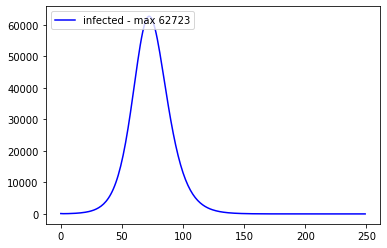

In [49]:
N = 946002
I0 = 117
R0 = 0
E0 = 0
time_range = range(250)
r0, dur_inf, dur_inc = (2.2, 2.9, 5.2)
plot_SEIR(time_range, E0, I0, R0, r0, dur_inf, dur_inc)

### calibrate to italian case

calibrating with genetic algorithm...
total deaths 16133.000000000002
r0 4.985235167638902
infection period in days 17.166740812875904
incubation period in days 1.0012200222160006
mae  73423
max number of infections  27767510
peak of infections  62
max number of exposed  2814400
max number of recovered  61396857


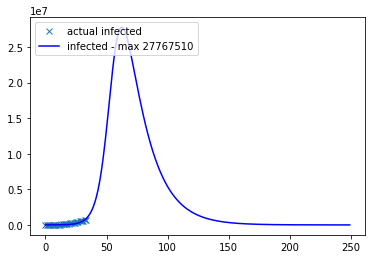

In [50]:
cases_multiplier = 10
df = pd.read_csv('../data/dpc-covid19-ita-andamento-nazionale.csv').drop('stato',1)
N = 61836230# 60431283
I0 = cases_multiplier*df['totale_attualmente_positivi'].iloc[0]
y_fit = cases_multiplier * df['totale_attualmente_positivi'].values
R0 = 0
E0 = 0
time_range = range(250)
r0, dur_inf, dur_inc = calibrate_SEIR(y_fit = y_fit,               
                                      N = N,
                                      I0 = I0,
                                      R0 = R0,
                                      E0 = E0,
                                      CFR = 0.02,
                                      time_horizon = 365,
                                      bounds= [(0,5), (1, 30), (1, 30)],
                                      use_differential_evolution = True)
plot_SEIR(time_range, E0, I0, R0, r0, dur_inf, dur_inc, y_fit)

## SEIRD Model definition

In [88]:
def SEIRDModel(t, S0, E0, I0, R0, D0, r0, dur_inf, dur_inc, theta):
    # SEIR model differential equations
    def SEIRD_deriv(y, t, r0, dur_inf, dur_inc, theta):
        S, E, I, R, D = y
        alpha = 1/dur_inc
        gamma = 1/dur_inf
        beta = r0 * (gamma)# + theta)
        dSdt = -beta * S * I/N
        dEdt = beta * S * I/N - alpha * E
        dIdt = alpha * E - gamma * I# - theta * I
        dRdt = gamma * I * (1 - theta)
        dDdt = theta * I# * (1 - gamma)
        return dSdt, dEdt, dIdt, dRdt, dDdt
    # Initial conditions vector
    y0 = S0, E0, I0, R0, D0
    # Integrate the SIR equations over time t
    ret = odeint(SEIRD_deriv, y0, t, args=(r0, dur_inf, dur_inc, theta))
    S, E, I, R, D = ret.T
    return S, E, I, R, D

def calibrate_SEIRD(y_fit,
                   N,
                   I0,
                   R0 = 0,
                   E0 = 0,
                   D0 = 0,                   
                   time_horizon = 365,
                   bounds= [(0,5), (1, 30), (1, 30), (0,1.)],
                   use_differential_evolution = True):
    
    # SEIR model differential equations
    def SEIRD_deriv(y, t, r0, dur_inf, dur_inc, theta):
        S, E, I, R, D = y
        alpha = 1/dur_inc
        gamma = 1/dur_inf
        beta = r0 * (gamma + theta)
        dSdt = -beta * S * I/N
        dEdt = beta * S * I/N - alpha * E
        dIdt = alpha * E - gamma * I# - theta * I
        dRdt = gamma * I * (1 - theta)
        dDdt = theta * I# * (1 - gamma)
        return dSdt, dEdt, dIdt, dRdt, dDdt

    def SEIRDModel_solver(t, r0, dur_inf, dur_inc, theta):
        # Initial conditions vector
        y0 = S0, E0, I0, R0, D0
        # Integrate the SIR equations over time t
        ret = odeint(SEIRD_deriv, y0, t, args=(r0, dur_inf, dur_inc, theta))
        S, E, I, R, D = ret.T
        return D

    def diff_ev_solver(params):
        r0, dur_inf, dur_inc, theta = params
        return np.mean(np.abs(SEIRDModel_solver(x_fit, r0, dur_inf, dur_inc, theta) - y_fit))    
    
    x_fit = np.linspace(0, len(y_fit), len(y_fit))
    S0 = N - I0 - R0 - E0 - D0 # Initial susceptible population to infection.
    if use_differential_evolution:
        print('calibrating with genetic algorithm...')
        optimization = differential_evolution(diff_ev_solver, bounds, popsize=150, maxiter=10000)
        params = optimization.x
    else:
        lo_bound = []
        up_bound = []
        for bound in bounds:
            lo_bound.append(bound[0])
            up_bound.append(bound[1])
        params, _ = curve_fit(f=SEIRDModel_solver, xdata=x_fit, ydata=y_fit,
                                method='trf', bounds=(lo_bound, up_bound))
    r0, dur_inf, dur_inc, theta = params
    
    #total_deaths = integrate.quad(lambda x: CFR*SEIRModel((x,), S0, E0, I0, R0, r0, dur_inf, dur_inc)[2], 0, 250)[0]

    print('CFR ', theta)
    print('r0', params[0])
    print('infection period in days', params[1])
    print('incubation period in days', params[2])
    print('mae ',int(np.mean(np.abs(y_fit-SEIRDModel_solver(x_fit, *params)))))
    return r0, dur_inf, dur_inc, theta

def plot_SEIRD(time_range, E0, I0, R0, D0, r0, dur_inf, dur_inc, theta, y = None):
    
    S0 = N - I0 - R0 - E0 - D0
    S, E, I, R, D = SEIRDModel(time_range, S0, E0, I0, R0, D0, r0, dur_inf, dur_inc, theta)
    print('max number of infections ', int(np.max(I)))
    print('peak of infections ', np.argmax(I))
    print('max number of exposed ', int(np.max(E)))
    print('max number of recovered ', int(np.max(R)))
    print('max number of deaths ', int(np.max(D)))
    
    fig, ax1 = plt.subplots()
    if y is not None:
        ax1.plot(y,'x', label='actual deaths')
    ax1.plot(I,'b', label='infected - max '+str(int(np.max(I))))
    ax1.plot(D,'r', label='deaths - max '+str(int(np.max(D))))
    #x1.plot(E,'y', label='exposed')
    ax1.legend(loc='upper left')

    

### check model params

max number of infections  3150220
peak of infections  158
max number of exposed  5283637
max number of recovered  46647956
max number of deaths  2564453


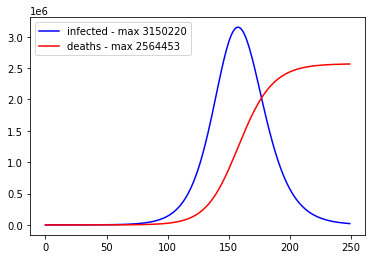

In [89]:
cases_multiplier = 10
df = pd.read_csv('../data/dpc-covid19-ita-andamento-nazionale.csv').drop('stato',1)
N = 61836230
I0 = 120
R0 = 0
E0 = 0
D0 = 0
time_range = range(250)
r0, dur_inf, dur_inc, theta = (1.9, 3.61, 5.95, 0.015)
plot_SEIRD(time_range, E0, I0, R0, D0, r0, dur_inf, dur_inc, theta)

### calibrate to italian case

calibrating with genetic algorithm...
CFR  0.10114287871839023
r0 1.3151951524230145
infection period in days 26.246158584478835
incubation period in days 1.019067149302817
mae  231
max number of infections  3623
peak of infections  249
max number of exposed  182
max number of recovered  10230
max number of deaths  30212


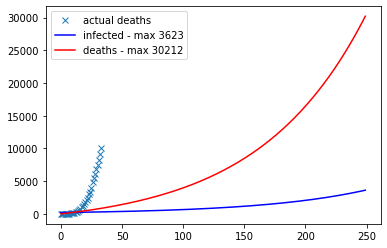

In [92]:
cases_multiplier = 1
df = pd.read_csv('../data/dpc-covid19-ita-andamento-nazionale.csv').drop('stato',1)
N = 61836230# 60431283
I0 = cases_multiplier*df['totale_attualmente_positivi'].iloc[0]
y_fit = df['deceduti'].values
R0 = 0
E0 = 0
D0 = 0
time_range = range(250)
r0, dur_inf, dur_inc, theta = calibrate_SEIRD(y_fit = y_fit,               
                                      N = N,
                                      I0 = I0,
                                      R0 = R0,
                                      E0 = E0,
                                      D0 = D0,
                                      time_horizon = 365,
                                      bounds= [(0,5), (1, 30), (1, 30), (0,1)],
                                      use_differential_evolution = True)
plot_SEIRD(time_range, E0, I0, R0, D0, r0, dur_inf, dur_inc, theta, y_fit)

## SEIIIRD Model definition

In [248]:
def SEIIIRDModel(t, S0, E0, I10, I20, I30, R0, D0, beta1, beta2, beta3, 
                 IncubPeriod, DurMildInf, FracSevere, FracCritical,  
                 DurHosp, ICUPeriod, CFR):
    # SEIR model differential equations
    def SEIIIRD_deriv(y, t, beta1, beta2, beta3, IncubPeriod, DurMildInf, 
                      FracSevere, FracCritical,  
                      DurHosp, ICUPeriod, CFR):
        S, E, I1, I2, I3, R, D = y
        N = S + E + I1 + I2 + I3 + R + D
        FracMild = 1. - FracSevere - FracCritical
        alpha = 1/IncubPeriod
        gamma1= (1/DurMildInf)*FracMild
        p1 = (1/DurMildInf)-gamma1
        p2 = (1/DurHosp)*(FracCritical/(FracSevere+FracCritical))
        gamma2 = (1/DurHosp)-p2
        mu = (1/ICUPeriod)*(CFR/FracCritical)
        gamma3 = (1/ICUPeriod)-mu
        dSdt = -(beta1*I1 + beta2*I2 + beta3*I3) * S/N
        dEdt =  (beta1*I1 + beta2*I2 + beta3*I3) * S/N - alpha*E
        dI1dt = alpha*E - (gamma1 + p1)*I1
        dI2dt = p1*I1 - (gamma2 + p2)*I2
        dI3dt = p2*I2 - (gamma3 + mu)*I3 
        dRdt = gamma1*I1 + gamma2*I2 + gamma3*I3 
        dDdt = mu*I3
        return dSdt, dEdt, dI1dt, dI2dt, dI3dt, dRdt, dDdt
    # Initial conditions vector
    y0 = S0, E0, I10, I20, I30, R0, D0
    # Integrate the SIR equations over time t
    ret = odeint(SEIIIRD_deriv, y0, t, args=(beta1, beta2, beta3, IncubPeriod,
                                             DurMildInf,FracSevere,FracCritical, 
                                             DurHosp,ICUPeriod,CFR))
    S, E, I1, I2, I3, R, D = ret.T
    return S, E, I1, I2, I3, R, D


def calibrate_SEIIIRD(y_fit,
                   S0,
                   I10,
                   I20 = 0,
                   I30 = 0,
                   R0 = 0,
                   E0 = 0,
                   D0 = 0,                   
                   time_horizon = 365,
                   bounds= None,
                   use_differential_evolution = False):

    # helper functions
    def SEIIIRD_differential(y, t, beta1, beta2, beta3, IncubPeriod, DurMildInf, 
                      FracSevere, FracCritical,DurHosp, DurICU, CFR):
        S, E, I1, I2, I3, R, D = y
        N = S + E + I1 + I2 + I3 + R + D
        FracMild = 1. - FracSevere - FracCritical
        alpha = 1/IncubPeriod
        gamma1= (1/DurMildInf)*FracMild
        p1 = (1/DurMildInf)-gamma1
        p2 = (1/DurHosp)*(FracCritical/(FracSevere+FracCritical))
        gamma2 = (1/DurHosp)-p2
        mu = (1/DurICU)*(CFR/FracCritical)
        gamma3 = (1/DurICU)-mu
        dSdt = -(beta1*I1 + beta2*I2 + beta3*I3) * S/N
        dEdt =  (beta1*I1 + beta2*I2 + beta3*I3) * S/N - alpha*E
        dI1dt = alpha*E - (gamma1 + p1)*I1
        dI2dt = p1*I1 - (gamma2 + p2)*I2
        dI3dt = p2*I2 - (gamma3 + mu)*I3 
        dRdt = gamma1*I1 + gamma2*I2 + gamma3*I3 
        dDdt = mu*I3
        return dSdt, dEdt, dI1dt, dI2dt, dI3dt, dRdt, dDdt


    def SEIIIRDModel_solver(t, beta1, beta2, beta3, IncubPeriod, DurMildInf, 
                      FracSevere, FracCritical, DurHosp, DurICU, CFR):
        # Initial conditions vector
        y0 = S0, E0, I10, I20, I30, R0, D0
        # Integrate the SEIIIRD equations over time t
        ret = odeint(SEIIIRD_differential, y0, t, args=(beta1, beta2, beta3,
                                               IncubPeriod, DurMildInf,
                                               FracSevere,FracCritical,
                                               DurHosp, DurICU, CFR))
        S, E, I1, I2, I3, R, D = ret.T
        OUTPUT = I1+I2+I3+D
        return OUTPUT

    def cost_fun(params):
        beta1,beta2,beta3,IncubPeriod,DurMildInf,FracSevere,FracCritical,DurHosp,DurICU,CFR=params
        return np.mean(np.abs(SEIIIRDModel_solver(x_fit, beta1, beta2, beta3, IncubPeriod, 
                            DurMildInf, FracSevere, FracCritical, DurHosp, DurICU, CFR) - y_fit))    
    
    x_fit = np.linspace(0, len(y_fit), len(y_fit))
    S0_ = N - I10 - I20 - I30 - R0 - E0 - D0 # Initial susceptible population to infection.
    if use_differential_evolution:
        print('calibrating with genetic algorithm...')
        optimization = differential_evolution(cost_fun, bounds, popsize=150, maxiter=10000)
        params = optimization.x
    else:
        if bounds is not None:
            lo_bound = []
            up_bound = []
            for bound in bounds:
                lo_bound.append(bound[0])
                up_bound.append(bound[1])
        else:
            lo_bound = None
            up_bound = None
        params, _ = curve_fit(f=SEIIIRDModel_solver, xdata=x_fit, ydata=y_fit,
                                method='trf', bounds=(lo_bound, up_bound))
    beta1,beta2,beta3,IncubPeriod,DurMildInf,FracSevere,FracCritical,DurHosp,TimeICUDeath,CFR=params

    print('beta1', beta1)
    print('beta2', beta2)
    print('beta3', beta3)
    print('IncubPeriod', IncubPeriod)
    print('DurMildInf', DurMildInf)
    print('FracSevere', FracSevere)
    print('FracCritical', FracCritical)
    print('DurHosp', DurHosp)
    print('DurICU', DurICU)
    print('CFR', CFR)
        
    #print('r0', params[0])
    print('mae ',int(np.mean(np.abs(y_fit-SEIIIRDModel_solver(x_fit, *params)))))
    return params

def plot_SEIIIRD(time_range, S0, E0, I10, I20, I30, 
                                          R0, D0, beta1, beta2, beta3, 
                                          IncubPeriod, DurMildInf, 
                                          FracSevere, FracCritical,  
                                          DurHosp, DurICU, CFR, 
                                          output=['I', 'D'],y_actual = None):
    
    S, E, I1, I2, I3, R, D = SEIIIRDModel(time_range, S0, E0, I10, I20, I30, 
                                          R0, D0, beta1, beta2, beta3, 
                                          IncubPeriod, DurMildInf, 
                                          FracSevere, FracCritical,  
                                          DurHosp, DurICU, CFR)
    I = I1+I2+I3
    print('max number of infections ', int(np.max(I)))
    print('peak of infections ', np.argmax(I))
    print('max number of exposed ', int(np.max(E)))
    print('max number of recovered ', int(np.max(R)))
    print('max number of deaths ', int(np.max(D)))
    
    plot_cases = {'I':I, 'I1':I1, 'I2':I2, 'I3':I3, 'S':S, 'E':E, 'R':R, 'D':D}
    fig, ax1 = plt.subplots()
    if y_actual is not None:
        ax1.plot(y_actual,'x', label='actual infected')
    for item in output:
        
        ax1.plot(plot_cases[item], label=item+' - max '+str(int(np.max(plot_cases[item]))))
    ax1.legend(loc='upper left')
    return S, E, I, I1, I2, I3, R, D

### check model params

max number of infections  12052181
peak of infections  100
max number of exposed  9197725
max number of recovered  55881778
max number of deaths  1140441


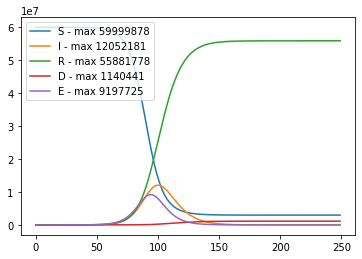

In [260]:
cases_multiplier = 10
df = pd.read_csv('../data/dpc-covid19-ita-andamento-nazionale.csv').drop('stato',1)
N = 60000000
I10 = 122
I20 = 0
I30 = 0
R0 = 0
E0 = 0
D0 = 0
S0 = N-I10-I20-I30-R0-E0-D0
time_range = range(250)
beta1 = 0.5
beta2 = 0.1
beta3 = 0.1
IncubPeriod = 5
DurMildInf = 6
FracSevere = 0.15
FracCritical = 0.05

#FracMild = 1. - FracCritical - FracSevere
DurHosp = 6
DurICU = 8
CFR = 0.02
S, E, I, I1, I2, I3, R, D = plot_SEIIIRD(time_range, S0, E0, I10, I20, I30, 
                                          R0, D0, beta1, beta2, beta3, 
                                          IncubPeriod, DurMildInf, 
                                          FracSevere, FracCritical,  
                                          DurHosp, DurICU, CFR,
                                     output = ['S', 'I', 'R', 'D', 'E'])

In [261]:
I1.max()

9951081.17230784

In [262]:
I2.max()

1820608.0010011997

In [263]:
I3.max()

539116.2754062185

In [264]:
E.max()

9197725.301049566

In [265]:
R.max()

55881778.027743965

In [266]:
S.min()

2977761.680260741

In [267]:
D[-1]

1140441.8199609919

In [268]:
S[-1]

2977761.680260741

### calibrate to italian case

In [298]:
cases_multiplier*I10

5525

beta1 0.8263568369653527
beta2 0.05803152644930442
beta3 0.08197125564197595
IncubPeriod 12.21136904763376
DurMildInf 17.70271685949589
FracSevere 0.8283997853858156
FracCritical 0.08564377303217399
DurHosp 15.786648136576677
DurICU 18.612004939196275
CFR 0.05975433686946845
mae  41154
max number of infections  36332091
peak of infections  74
max number of exposed  26716604
max number of recovered  56803810
max number of deaths  3606356


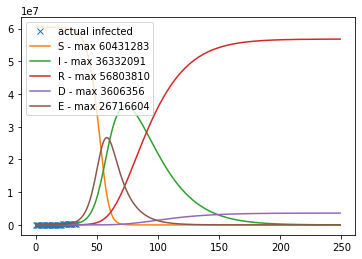

In [300]:
cases_multiplier = 5
deaths_multiplier = 2
df = pd.read_csv('../data/dpc-covid19-ita-andamento-nazionale.csv').drop('stato',1)
N = 60431283
I10 = cases_multiplier*df['totale_attualmente_positivi'].iloc[0]
y_fit = cases_multiplier*df['totale_attualmente_positivi'] + deaths_multiplier*df['deceduti'].values
I20 = 0
I30 = 0
R0 = 0
E0 = 0
D0 = 0
S0 = N - E0 - I10 - I20 - I30 - R0 - D0 
time_range = range(250)
beta1, beta2, beta3, IncubPeriod, DurMildInf, FracSevere, FracCritical,  DurHosp, DurICU, CFR = calibrate_SEIIIRD(
    y_fit = y_fit,               
    S0 = S0,
    I10 = I10,
    I20 = I20,
    I30 = I30,
    R0 = R0,
    E0 = E0,
    D0 = D0,
    time_horizon = 365,
    bounds= [
        (0, .9), #beta1
        (0, .1), #beta2
        (0, .1), #beta3
        (1, 30), #IncubPeriod
        (1, 30), #DurMildInf
        (0, 1), #FracSevere
        (0, 0.1),#FracCritical
        (1, 30), #DurHosp
        (1, 30), #DurICU
        (0, 0.1), #CFR
       ],
    use_differential_evolution = False)
S, E, I, I1, I2, I3, R, D  = plot_SEIIIRD(time_range, N, E0, I10, I20, I30, 
                                          R0, D0, beta1, beta2, beta3, 
            IncubPeriod, DurMildInf, FracSevere, FracCritical, DurHosp, 
            DurICU, CFR, y_actual=y_fit, output = ['S', 'I', 'R', 'D', 'E'])

In [302]:
I1.max()

23501497.260340262

In [291]:
I2.max()

14599764.408490937

In [292]:
I3.max()

1126517.2272623624

In [293]:
E.max()

26716604.99244841

In [294]:
R.max()

56803810.25164537

In [295]:
S.min()

10.414057969881453

In [296]:
D[-1]

3606356.5884434422

In [297]:
S[-1]

10.414057969881453

In [ ]:
cases_multiplier = 5
deaths_multiplier = 2
df = pd.read_csv('../data/dpc-covid19-ita-andamento-nazionale.csv').drop('stato',1)
N = 60431283
I10 = cases_multiplier*df['totale_attualmente_positivi'].iloc[0]
y_fit = cases_multiplier*df['totale_attualmente_positivi'] + deaths_multiplier*df['deceduti'].values
I20 = 0
I30 = 0
R0 = 0
E0 = 0
D0 = 0
S0 = N - E0 - I10 - I20 - I30 - R0 - D0 
time_range = range(250)
beta1, beta2, beta3, IncubPeriod, DurMildInf, FracSevere, FracCritical,  DurHosp, DurICU, CFR = calibrate_SEIIIRD(
    y_fit = y_fit,               
    S0 = S0,
    I10 = I10,
    I20 = I20,
    I30 = I30,
    R0 = R0,
    E0 = E0,
    D0 = D0,
    time_horizon = 365,
    bounds= [
        (0, .9), #beta1
        (0, .1), #beta2
        (0, .1), #beta3
        (1, 30), #IncubPeriod
        (1, 30), #DurMildInf
        (0, 1), #FracSevere
        (0, 0.1),#FracCritical
        (1, 30), #DurHosp
        (1, 30), #DurICU
        (0, 0.1), #CFR
       ],
    use_differential_evolution = True)
vals = plot_SEIIIRD(time_range, N, E0, I10, I20, I30, R0, D0, beta1, beta2, beta3, 
            IncubPeriod, DurMildInf, FracSevere, FracCritical, DurHosp, 
            DurICU, CFR, y_actual=y_fit, output = ['S', 'I', 'R', 'D', 'E'])

calibrating with genetic algorithm...


#### temptative models

In [161]:
def func(y, t, N, I0, R0, D_incubation, D_infectious, D_recovery_mild, 
         D_hospital_lag, D_recovery_severe, D_death, P_SEVERE, CFR, 
         InterventionTime, InterventionAmt, duration):
    
    interpolation_steps = 40
    steps = 110*interpolation_steps
    dt = dt/interpolation_steps
    sample_step = interpolation_steps
# SEIR ODE
    if (t > InterventionTime & t < InterventionTime + duration):
        beta = (InterventionAmt)*R0/(D_infectious)
    elif(t > InterventionTime + duration):
        beta = 0.5*R0/(D_infectious)        
    else:
        beta = R0/(D_infectious)

    a     = 1/D_incubation
    gamma = 1/D_infectious

    S         = y[0] # Susectable
    E         = y[1] # Exposed
    I         = y[2] # Infectious 
    Mild      = y[3] # Recovering (Mild)     
    Severe    = y[4] # Recovering (Severe at home)
    Severe_H  = y[5] # Recovering (Severe in hospital)
    Fatal     = y[6] # Recovering (Fatal)
    R_Mild    = y[7] # Recovered
    R_Severe  = y[8] # Recovered
    R_Fatal   = y[9] # Dead
    p_severe  = P_SEVERE
    p_fatal   = CFR
    p_mild    = 1 - P_SEVERE - CFR
    dS        = -beta*I*S
    dE        =  beta*I*S - a*E
    dI        =  a*E - gamma*I
    dMild     =  p_mild*gamma*I   - (1/D_recovery_mild)*Mild
    dSevere   =  p_severe*gamma*I - (1/D_hospital_lag)*Severe
    dSevere_H =  (1/D_hospital_lag)*Severe - (1/D_recovery_severe)*Severe_H
    dFatal    =  p_fatal*gamma*I  - (1/D_death)*Fatal
    dR_Mild   =  (1/D_recovery_mild)*Mild
    dR_Severe =  (1/D_recovery_severe)*Severe_H
    dR_Fatal  =  (1/D_death)*Fatal
    
    return dS, dE, dI, dMild, dSevere, dSevere_H, dFatal, dR_Mild, dR_Severe, dR_Fatal

In [23]:
#https://towardsdatascience.com/social-distancing-to-slow-the-coronavirus-768292f04296
def base_seir_model(init_vals, params, t):
    S_0, E_0, I_0, R_0 = init_vals
    S, E, I, R = [S_0], [E_0], [I_0], [R_0]
    alpha, beta, gamma = params
    dt = t[1] - t[0]
    for _ in t[1:]:
        next_S = S[-1] - (beta*S[-1]*I[-1])*dt
        next_E = E[-1] + (beta*S[-1]*I[-1] - alpha*E[-1])*dt
        next_I = I[-1] + (alpha*E[-1] - gamma*I[-1])*dt
        next_R = R[-1] + (gamma*I[-1])*dt
        S.append(next_S)
        E.append(next_E)
        I.append(next_I)
        R.append(next_R)
    return np.stack([S, E, I, R]).T

In [28]:
# Define parameters
t_max = 100
dt = .1
t = np.linspace(0, t_max, int(t_max/dt) + 1)
N = 10000
init_vals = 1 - 1/N, 1/N, 0, 0
alpha = 0.2
beta = 1.75
gamma = 0.5
params = alpha, beta, gamma
# Run simulation
results = base_seir_model(init_vals, params, t)

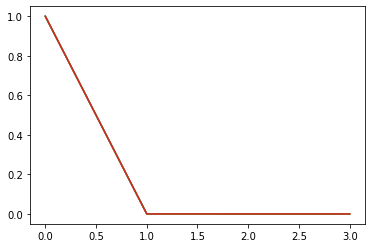

In [29]:
plt.plot(results[0], label='S')
plt.plot(results[1], label='E')
plt.plot(results[2], label='I')
plt.plot(results[3], label='R')